In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

from src.dataset_benchm import OVAS, GeoCrack, all_datasets, RandomColorJitter_Brightness_down, RandomColorJitter_Brightness_up, RandomColorJitter_Contrast, RandomColorJitter_Saturation, RandomGaussianBlur
from src.train import eval_loop

/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torchvision.transforms.v2 as t

In [3]:
dataset = GeoCrack('train', expand=False)
# dataset = Subset(dataset, np.arange(20))

In [17]:
a, b, c = all_datasets(datasets='geocrack', batch_size=1, shuffle_train=False, do_transform=True)

In [18]:
[t.Resize(256)(i).size() for i in dataset[0]]

[torch.Size([3, 256, 256]), torch.Size([1, 256, 256])]

In [19]:
len(dataset)

6079

In [20]:
next(iter(a))[0][0].shape

torch.Size([3, 256, 256])

/tmp/54475309/ipykernel_3640588/1298556338.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  axes[0].imshow(np.array(image))


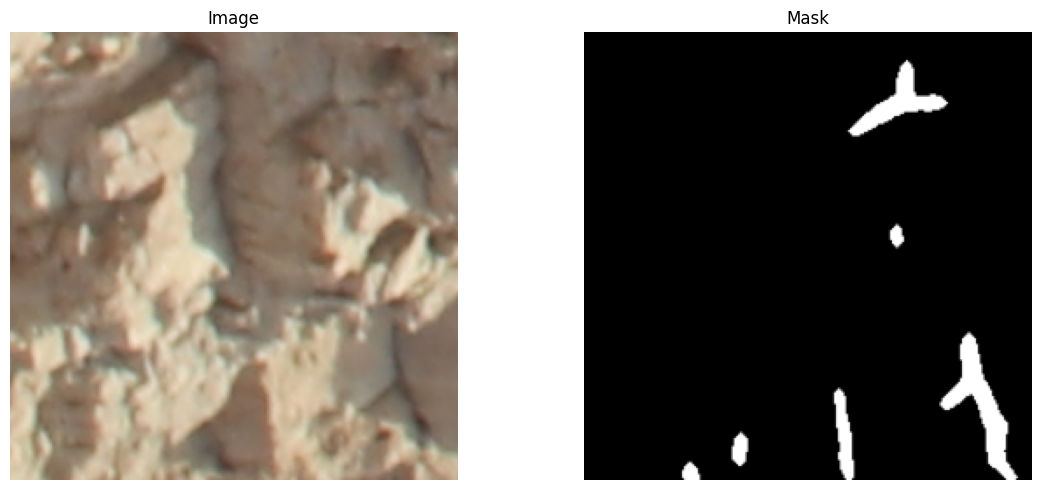

In [63]:
# ind = np.random.choice(range(len(dataset)))
# print(ind)
ind = 1370
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
tata = next(iter(a))
image, mask = tata[0][0], tata[1][0]
image = image.permute(1, 2, 0)[:, :, :3]
mask = mask.permute(1, 2, 0)

axes[0].imshow(np.array(image))
axes[0].set_title('Image')
axes[0].axis('off')
axes[0].grid([])

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')
axes[1].grid([])

fig.tight_layout()

In [26]:
import os

In [28]:
sorted(os.listdir('/users/afatihi/work-detect/fractex2D.pt/data/GeoCrack_/train/image'))[:10]

['0V5A3666_patch1.png',
 '0V5A3666_patch10.png',
 '0V5A3666_patch101.png',
 '0V5A3666_patch102.png',
 '0V5A3666_patch103.png',
 '0V5A3666_patch109.png',
 '0V5A3666_patch110.png',
 '0V5A3666_patch112.png',
 '0V5A3666_patch113.png',
 '0V5A3666_patch114.png']

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.v2 import RandomHorizontalFlip, RandomVerticalFlip, Compose
import torchvision.transforms.v2.functional as TF
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

def create_triangle_image(size=64):
    img = Image.new("RGB", (size, size), "black")
    draw = ImageDraw.Draw(img)
    draw.polygon([(63, 0), (63, 31), (32, 0)], fill="white")
    return img


class TriangleDataset(Dataset):
    def __init__(self, transform=None):
        pil_img = create_triangle_image()
        self.img = TF.pil_to_tensor(pil_img)
        self.mask = self.img[0].unsqueeze(0)  # 1 channel mask
        self.transform = transform

    def __getitem__(self, idx):
        img, mask = self.img, self.mask
        if self.transform:
            img, mask = self.transform(img, mask)
            
        if random.random() > 0.5:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        if random.random() > 0.5:
            img = TF.vflip(img)
            mask = TF.vflip(mask)
        return img, mask

    def __len__(self):
        return 1


transforms = None
_ = Compose([
    RandomHorizontalFlip(p=.50),
    RandomVerticalFlip(p=.50),
])

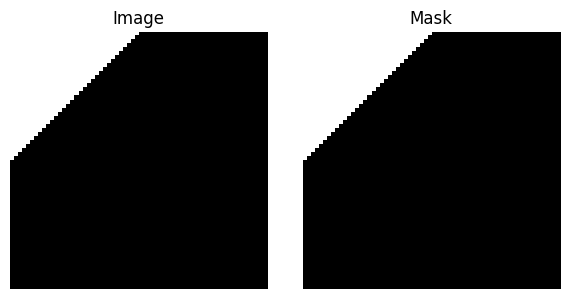

In [55]:
dataset = TriangleDataset(transform=transforms)
img, mask = next(iter(DataLoader(dataset)))

# Plot
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(img[0].permute(1, 2, 0), cmap='gray')
axs[0].set_title("Image")
axs[1].imshow(mask[0][0], cmap='gray')
axs[1].set_title("Mask")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [20]:
import os
import random
from typing import Any, Dict, List

import numpy as np
import torch
import torchvision.transforms.v2 as t
import torchvision.transforms.v2.functional as TF
from skimage import io
from skimage.filters.rank import maximum
from skimage.measure import label
from skimage.morphology import binary_dilation, dilation, disk
from skimage.segmentation import expand_labels
from torch.utils.data import ConcatDataset, DataLoader, Dataset

In [170]:
class GeoCrack(Dataset):

    def __init__(self, subset: str, use_list=True, topo=False, transform=None,
                 expand=True, dilate=True, in_channels=3):

        directory = 'data/GeoCrack_'
        ext = 'png'

        self.images = sorted(
            [os.path.join(directory, subset, 'image', fname)
                for fname in os.listdir(os.path.join(directory, subset, 'image'))
                if fname.endswith(ext)])
        self.masks = sorted(
            [os.path.join(directory, subset, 'gt', fname)
                for fname in os.listdir(os.path.join(directory, subset, 'gt'))
                if fname.endswith(ext)])

        self.topo = topo
        self.transform = transform
        self.expand = expand
        self.dilate = dilate
        self.in_channels = in_channels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):

        data_idx = index % len(self.images)

        image = io.imread(self.images[data_idx]).astype(np.uint8)
        gt = (io.imread(self.masks[data_idx])*255).astype(np.uint8)
        if self.expand:
            gt = expand_wide_fractures_gt(image[:, :, :3].astype(np.uint8), gt)
        if self.dilate:
            gt = dilate_labels(gt)

        image_tensor = torch.from_numpy(image[:, :, :self.in_channels])
        # fix dimensions (C, H, W)
        image_tensor = image_tensor.permute(2, 0, 1) / 255.
        mask_tensor = torch.from_numpy(gt).unsqueeze(0) / 255.

        # image_tensor = torch.cat((image_tensor, dem_tensor.unsqueeze(2)), 2)
        
        print(image_tensor.shape, mask_tensor.shape)

        if self.transform:
            image_tensor, mask_tensor = self.transform(
                image_tensor, mask_tensor)

        # if random.random() > 0.5:
        #     image_tensor = TF.hflip(image_tensor)
        #     mask_tensor = TF.hflip(mask_tensor)

        # if random.random() > 0.5:
        #     image_tensor = TF.vflip(image_tensor)
        #     print('done for image')
        #     mask_tensor = TF.vflip(mask_tensor)
        #     print('done for mask')

        image_tensor = t.Resize(256)(image_tensor)
        mask_tensor = t.Resize(256)(mask_tensor)
        
        print(image_tensor.shape, mask_tensor.shape)

        return image_tensor.float(), mask_tensor.float()

In [171]:
dilate = False
expand = False
do_transform = True
in_channels = 4

if not do_transform:
    transforms = None
else:
    transforms = t.Compose([
        t.RandomHorizontalFlip(p=0.5),
        t.RandomVerticalFlip(p=0.5),
        RandomGaussianBlur(p=0.05),
        RandomColorJitter_Brightness_down(p=.05),
        RandomColorJitter_Brightness_up(p=.05),
        RandomColorJitter_Contrast(p=.05),
        RandomColorJitter_Saturation(p=.05),
    ])

In [172]:
trainset_ = GeoCrack(subset='train', transform=transforms,
                                   expand=expand, dilate=dilate,
                                   in_channels=in_channels)

In [173]:
trainset_[0][1].shape

torch.Size([3, 224, 224]) torch.Size([1, 224, 224])
torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


torch.Size([1, 256, 256])

torch.Size([3, 224, 224]) torch.Size([1, 224, 224])
torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


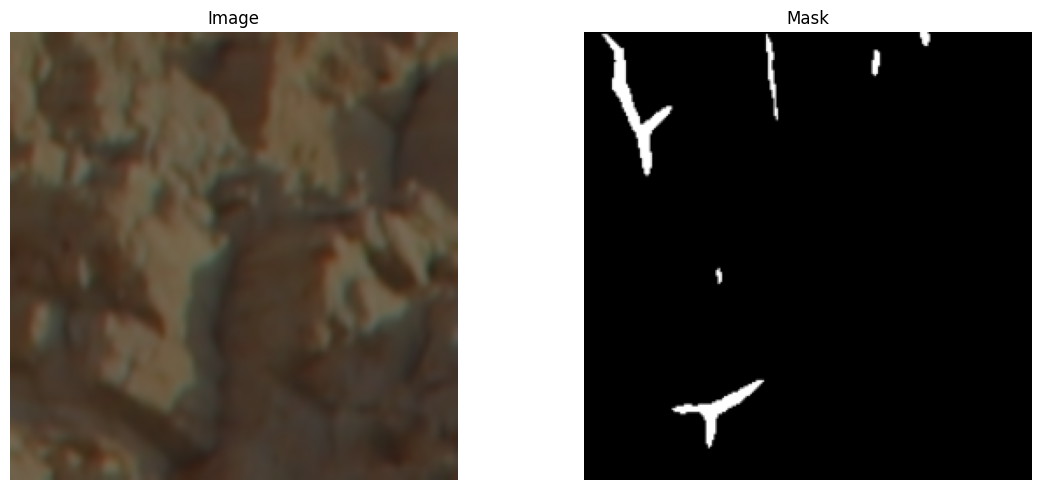

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
test = trainset_[0]
image, mask = test[0], test[1]
image = image.permute(1, 2, 0)[:, :, :3]
mask = mask.permute(1, 2, 0)

axes[0].imshow(image)
axes[0].set_title('Image')
axes[0].axis('off')
axes[0].grid([])

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')
axes[1].grid([])

fig.tight_layout()

# 